In [93]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
color_pal = sns.color_palette()
import xgboost as xgb 
from sklearn.metrics import mean_squared_error

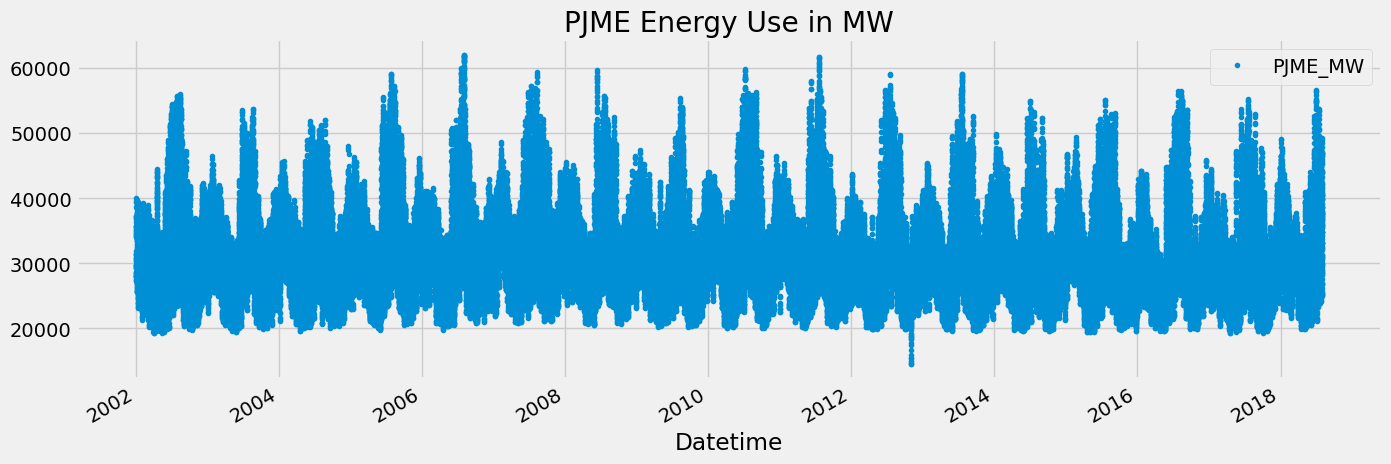

In [94]:
# Visualize entire dataset
df = pd.read_csv("Time Series Data/PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.plot(style = ".", 
        figsize = (15,5), 
        color = color_pal[0], 
        title = "PJME Energy Use in MW")
plt.show()

## Train / Test Split

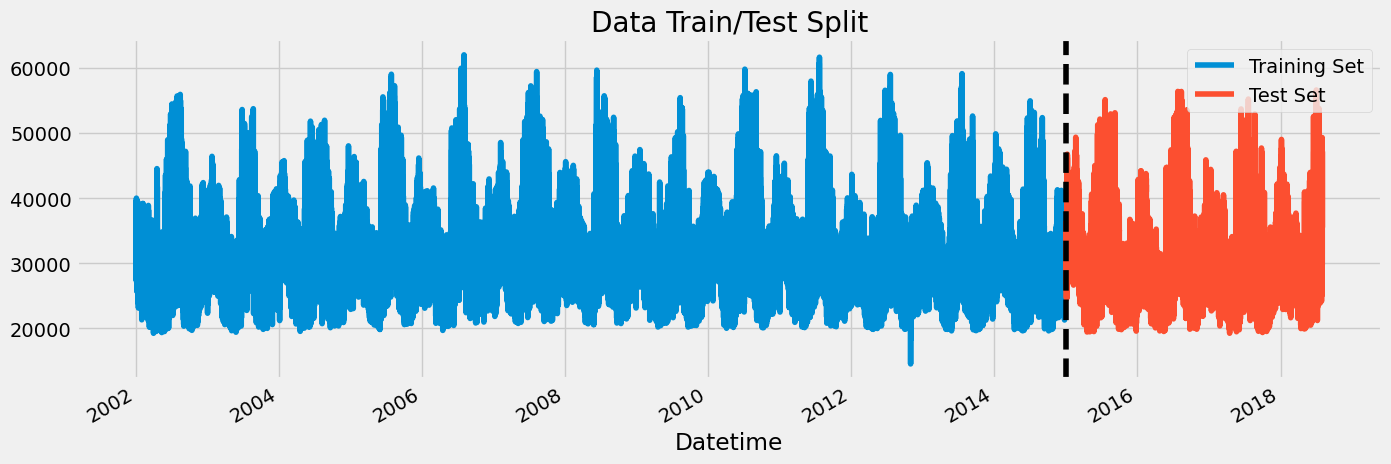

In [95]:
# Split data into training and testing set
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

fig, ax = plt.subplots(figsize = (15,5))

train.plot(ax = ax, label = "Training Set", title = "Data Train/Test Split")
test.plot(ax = ax, label = "Test Set")
ax.axvline("01-01-2015", color = "black", ls = "--")
ax.legend(["Training Set", "Test Set"])
plt.show()


<Axes: title={'center': 'Week Data'}, xlabel='Datetime'>

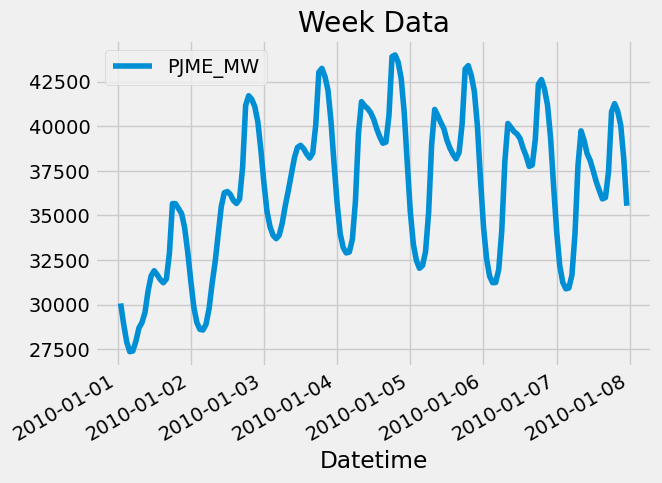

In [96]:
# Look data in one week.
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(title = "Week Data")

## Feature Creation

In [97]:
# Create time features to original dataset
def create_features(df):
    # Create time series features based on time series index.
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [98]:
df = create_features(df)

## Visualize Feature / Target Relationship

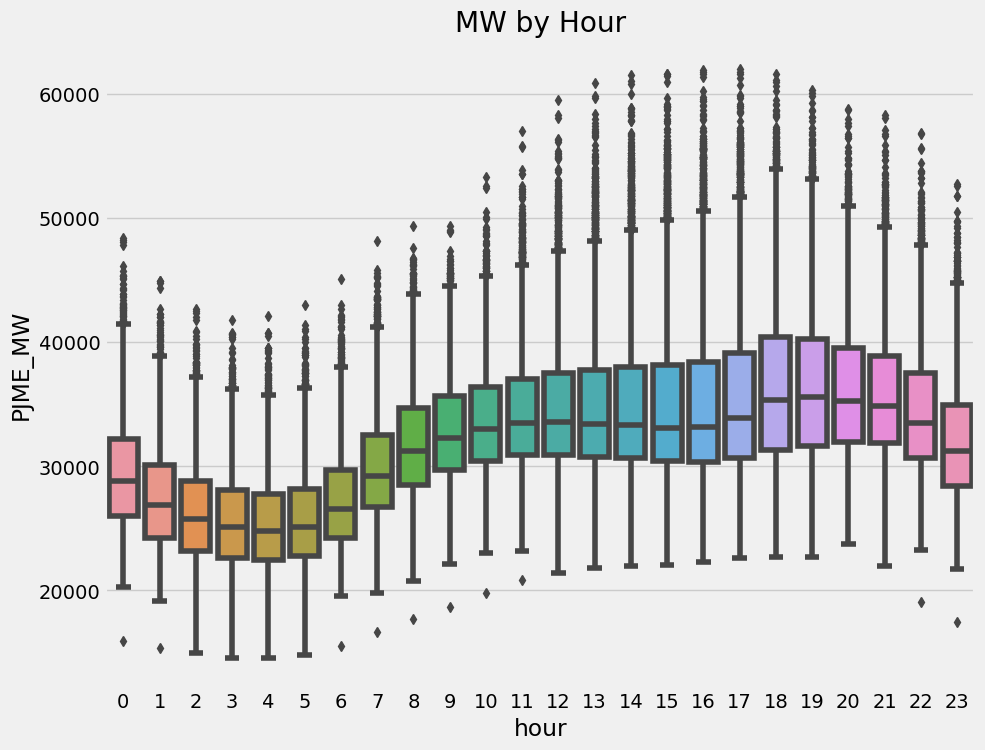

In [99]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

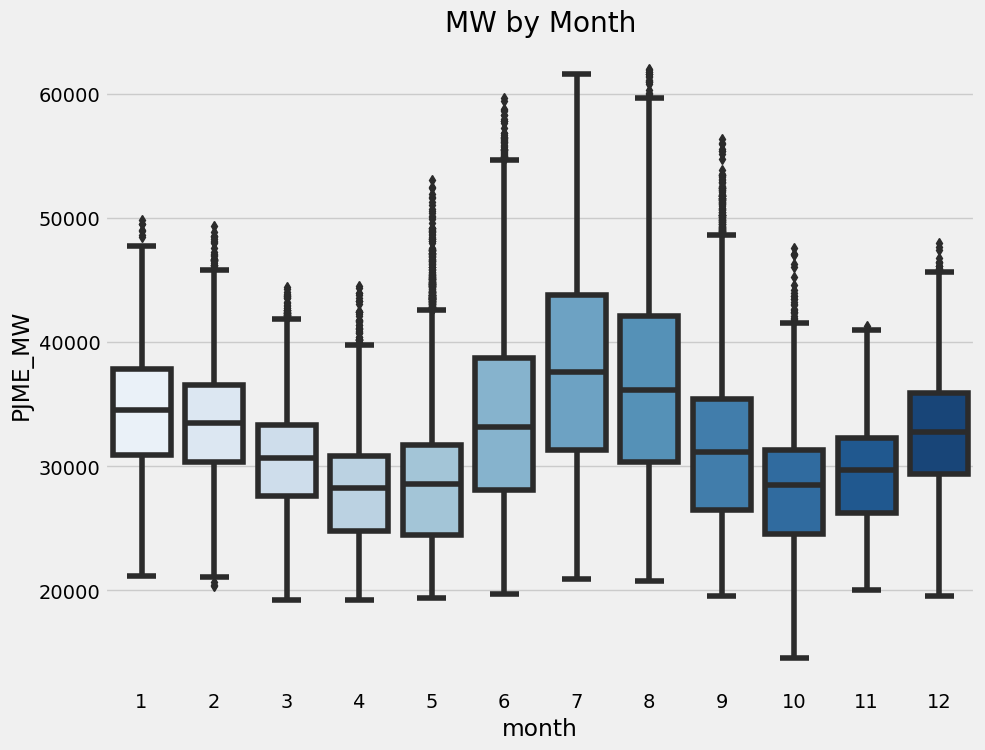

In [100]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'month', y = 'PJME_MW', palette = "Blues")
ax.set_title('MW by Month')
plt.show()

## Create Model

In [101]:
train = create_features(train)
test = create_features(test)
FEATURES = ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [102]:
#If test set doesn't improve for 50 rounds, early stops.  
reg = xgb.XGBRegressor(n_estimators = 1000,
                       early_stopping_rounds = 50,
                       learning_rate = 0.01)
reg.fit(X_train, y_train, 
        eval_set = [(X_train, y_train),(X_test, y_test)],
        verbose = 100)

# It stops on 417 since the test validation starts to get worse.

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

<Axes: title={'center': 'Feature Importance'}>

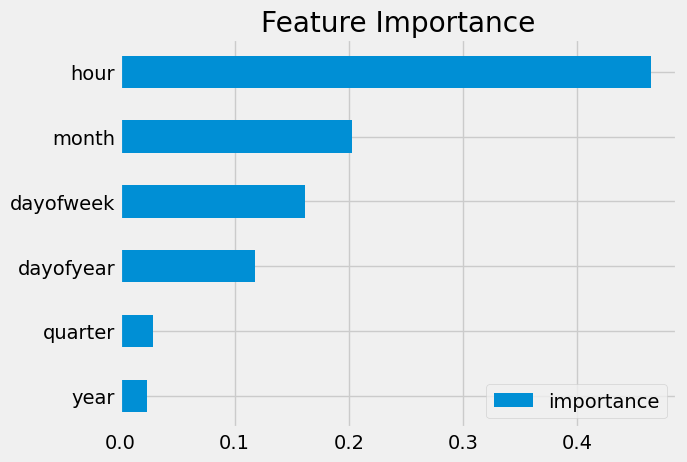

In [103]:
# When have highly correlated features, this cannot tell you how important each feature is individually. 
fi = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns = ['importance'])
fi.sort_values("importance").plot(kind = 'barh', title = 'Feature Importance')

## Forecast on Test

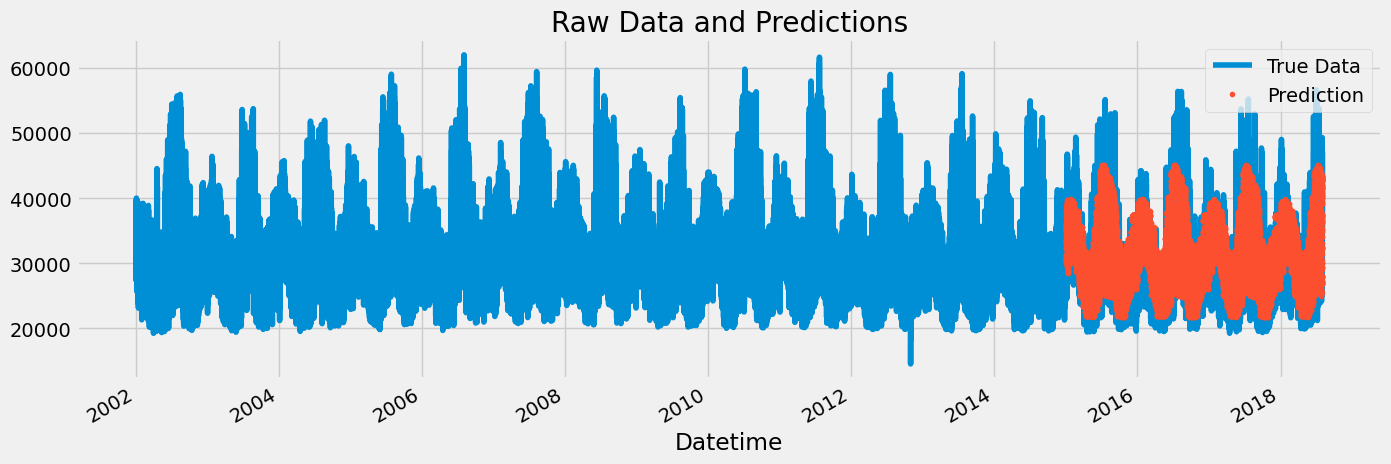

In [104]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)
ax = df[["PJME_MW"]].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = ".")
plt.legend(['True Data', "Prediction"])
ax.set_title("Raw Data and Predictions")
plt.show()

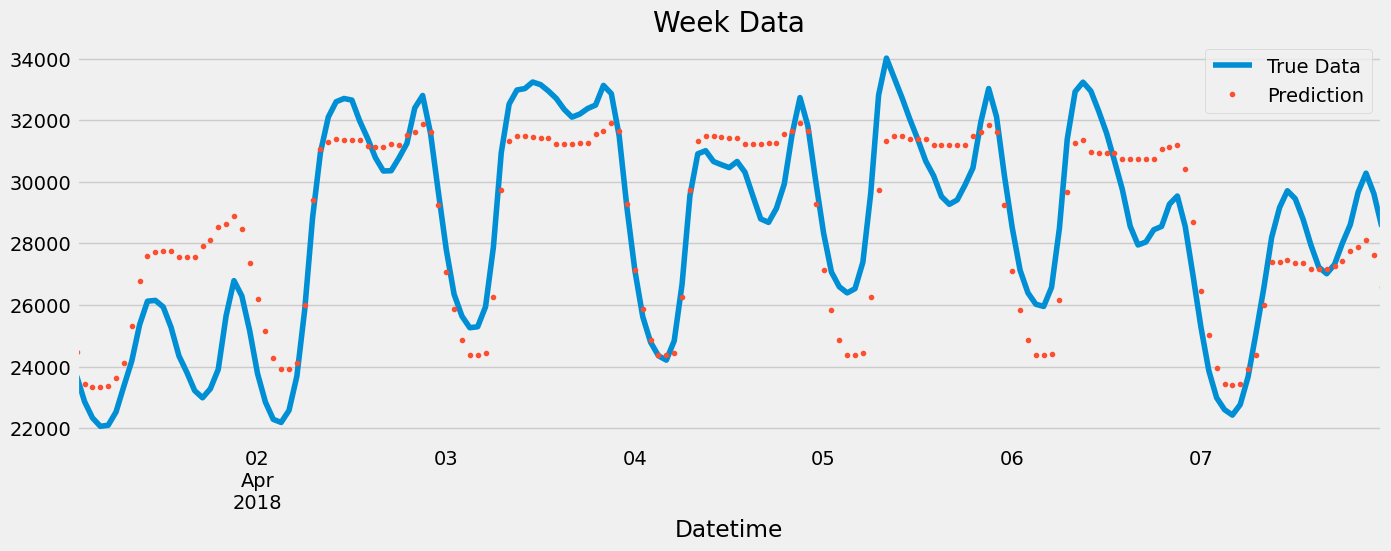

In [105]:
# Prediction result vs. actual result in a week.
ax = df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]['PJME_MW'].plot(figsize = (15,5),title = "Week Data")
df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]['prediction'].plot(style = '.')
plt.legend(['True Data', "Prediction"])
plt.show()

In [106]:
# Find the score of this model. 
score = np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f"RMSE score on Test set: {score:0.2f}")

RMSE score on Test set: 3741.03


## Calculate Error

In [107]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
# Worst 5 prediction
test.groupby('date')['error'].mean().sort_values(ascending = False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [108]:
# Best 5 prediction
test.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64